In [1]:
# Packages 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.signal_processing import *
from utils.fpp_simulation import *
from utils.plotting import *

In [2]:
def normalize_trace(trace):
    maxval = np.max(trace)
    return trace / maxval

def extract_segment(trace, index_cut):
     return trace[:index_cut]

def compare_kernel_normalized(kernel, kernel_time, psi, psi_time):
    
    psi_norm = normalize_trace(psi)
    
    plt.figure(figsize = (6, 3))
    plt.plot(psi_time, psi_norm, label = '$\Psi$ Pattern (Normalized)', color = 'red', linewidth = 3)
    plt.plot(kernel_time, kernel, label = 'Kernel', color = 'black', linestyle = '--', linewidth = 3)
    
    plt.title('Recovered vs. Original Kernel')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

def mae(kernel, psi):
    psi_norm = normalize_trace(psi)
    mae = np.mean(np.abs(kernel - psi_norm))
    print(f'Mean Absolute Error: {mae} ({(mae * 100):.2f}%)')

---
##### **Recovering Kernel Shape from Stochastic Interference**
A fundamental problem arises when the event rate is very high: it becomes impossible to determine the underlying kernel simply by observing the raw signal trace. In this context, the $\Psi$ operator (defined as the negative derivative of the signal's autocorrelation function) emerges as a solution, allowing for excellent reconstructions of the original kernel. 

This recovery method works perfectly with a wide variety of kernel functions, such as:
- Alpha and dual-exponential functions (commonly used to model synaptic events)
- Square pulses
- Exponential decay

##### **1. Dual-Exponential Kernel**

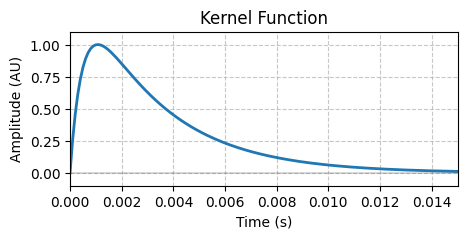

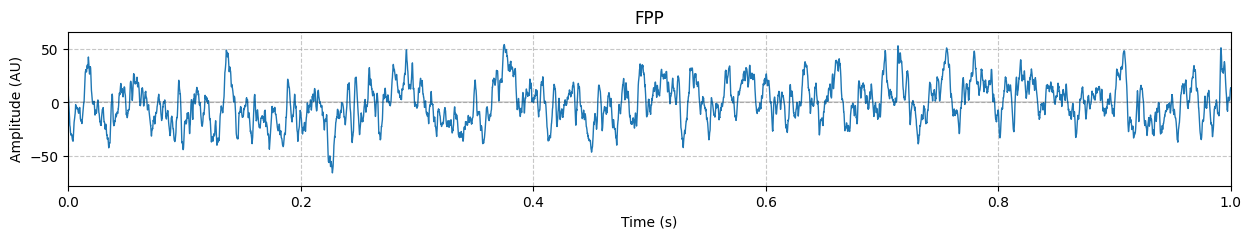

In [3]:
fs, t_sec = (10000, 300)

kernel_dexp, time_dexp = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = 0.5 / 1000,
                                          tau_decay_s = 3 / 1000, 
                                          max_amplitude = 1)

signal_dexp, time_signal_dexp, _ = simulate_fpp(kernel = kernel_dexp,
                                      fs = fs,
                                      t_sec = t_sec, 
                                      num_neurons = 2500, 
                                      rate = 50)

plot_trace(kernel_dexp, time_dexp, title = 'Kernel Function', xlim = (0, 0.015))
plot_trace(signal_dexp, time_signal_dexp, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP')

In [4]:
# Kernel recovery
psi_dexp, time_psi_dexp = psi_pattern(signal = signal_dexp, fs = fs)

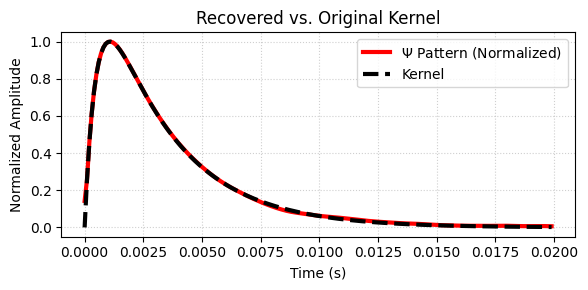

In [5]:
# We will only compare the important segment (first 20 ms)
time_cut = int(0.020 * fs)
kernel_seg_dexp, time_ker_seg_dexp = extract_segment(kernel_dexp, time_cut), extract_segment(time_dexp, time_cut)
psi_seg_dexp, time_psi_seg_dexp = extract_segment(psi_dexp, time_cut), extract_segment(time_psi_dexp, time_cut)

compare_kernel_normalized(kernel = kernel_seg_dexp, kernel_time = time_ker_seg_dexp, psi = psi_seg_dexp, psi_time = time_psi_seg_dexp)

In [6]:
mae(kernel = kernel_seg_dexp, psi = psi_seg_dexp)

Mean Absolute Error: 0.003553851530208872 (0.36%)


##### **2. Square Pulse**

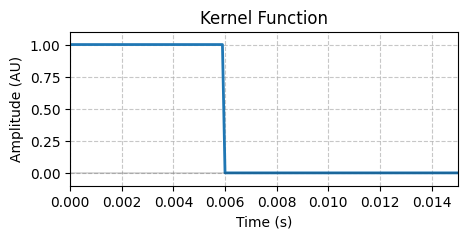

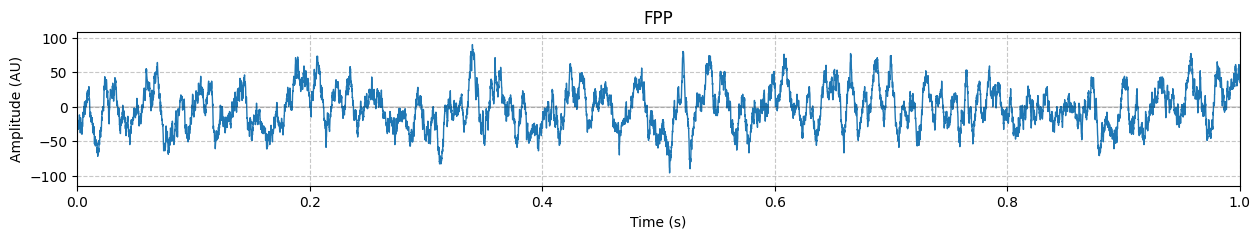

In [7]:
fs, t_sec = (10000, 300)

# We will only use constant amplitude for the square pulse
kernel_sq, time_sq = triple_square_kernel(t_sec = t_sec,
                                          fs = fs, 
                                          t1_s = 2 /  1000, 
                                          t2_s = 4 / 1000,
                                          t3_s = 6 / 1000)

signal_sq, time_signal_sq, _ = simulate_fpp(kernel = kernel_sq,
                                            fs = fs,
                                            t_sec = t_sec, 
                                            num_neurons = 2500, 
                                            rate = 50)

plot_trace(kernel_sq, time_sq, title = 'Kernel Function', xlim = (0, 0.015))
plot_trace(signal_sq, time_signal_sq, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP')

In [8]:
# Kernel recovery
psi_sq, time_psi_sq = psi_pattern(signal = signal_sq, fs = fs)

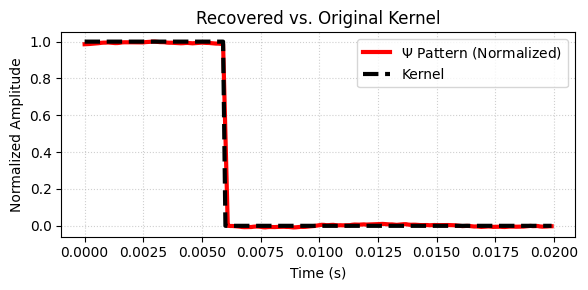

In [9]:
# We will only compare the important segment (first 20 ms)
time_cut = int(0.020 * fs)
kernel_seg_sq, time_ker_seg_sq = extract_segment(kernel_sq, time_cut), extract_segment(time_sq, time_cut)
psi_seg_sq, time_psi_seg_sq = extract_segment(psi_sq, time_cut), extract_segment(time_psi_sq, time_cut)

compare_kernel_normalized(kernel = kernel_seg_sq, kernel_time = time_ker_seg_sq, psi = psi_seg_sq, psi_time = time_psi_seg_sq)

In [10]:
mae(kernel = kernel_seg_sq, psi = psi_seg_sq)

Mean Absolute Error: 0.0077989627773586935 (0.78%)


As can be observed, the $\Psi$ pattern is capable of obtaining highly accurate reconstructions of the underlying kernel without the need for any additional information beyond the signal itself. Note that there are clear differences in scale between the pattern and the original kernel. However, after normalizing their amplitudes, the shape provides a very close approximation, with an error of less than 1% in most cases.

---
##### **Signals Composed of Multiple Kernels**

When multiple independent kernels coexist within a single signal, the resulting time series corresponds to the additive superposition of the individual processes:

$$ 
V_{\text{total}}(t) = \sum_{i=1}^{n} V_{k_i}(t) 
$$

Applying the $\Psi$ operator to this composite signal yields a linear combination of all underlying kernels:

$$
\Psi_{\text{total}}(\tau) = \sum_{i=1}^{n} \omega_i k_i(\tau)
$$

The weighting scalar $\omega_i$ reflects the relative contribution of each kernel. Consequently, kernels with a higher occurrence rate or greater average amplitude will exert a stronger influence on the resulting $\Psi$ profile, effectively "dominating" the reconstruction.

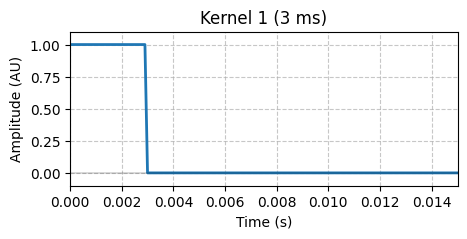

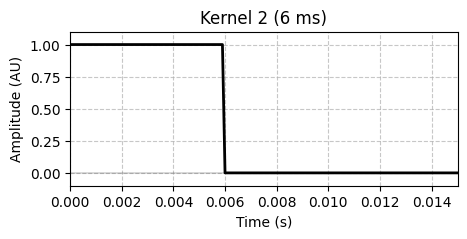

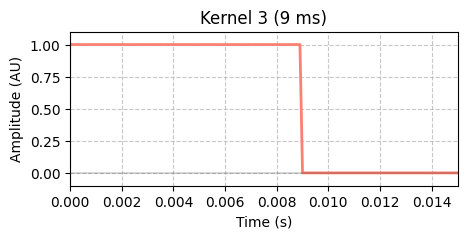

In [11]:
# Lets visualize this proprerty with three square pulses
fs, t_sec = (10000, 300)

kernel_sq1, time_sq1 = triple_square_kernel(t_sec = t_sec,
                                            fs = fs, 
                                            t1_s = 3 /  1000, 
                                            t2_s = 6 / 1000,
                                            t3_s = 9 / 1000,
                                            amplitude1 = 1.0,
                                            amplitude2 = 0.0,
                                            amplitude3 = 0.0)

kernel_sq2, time_sq2 = triple_square_kernel(t_sec = t_sec,
                                            fs = fs, 
                                            t1_s = 3 /  1000, 
                                            t2_s = 6 / 1000,
                                            t3_s = 9 / 1000,
                                            amplitude1 = 1.0,
                                            amplitude2 = 1.0,
                                            amplitude3 = 0.0)

kernel_sq3, time_sq3 = triple_square_kernel(t_sec = t_sec,
                                            fs = fs, 
                                            t1_s = 3 /  1000, 
                                            t2_s = 6 / 1000,
                                            t3_s = 9 / 1000,
                                            amplitude1 = 1.0,
                                            amplitude2 = 1.0,
                                            amplitude3 = 1.0)

plot_trace(kernel_sq1, time_sq1, title = 'Kernel 1 (3 ms)', xlim = (0, 0.015))
plot_trace(kernel_sq2, time_sq2, title = 'Kernel 2 (6 ms)', xlim = (0, 0.015), trace_color = 'black')
plot_trace(kernel_sq3, time_sq3, title = 'Kernel 3 (9 ms)', xlim = (0, 0.015), trace_color = 'salmon')

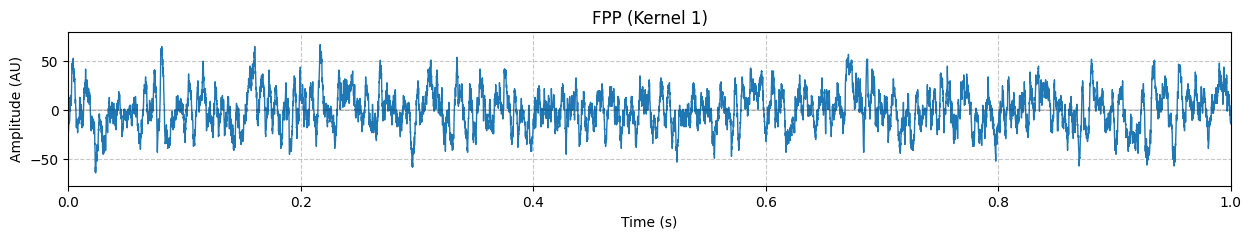

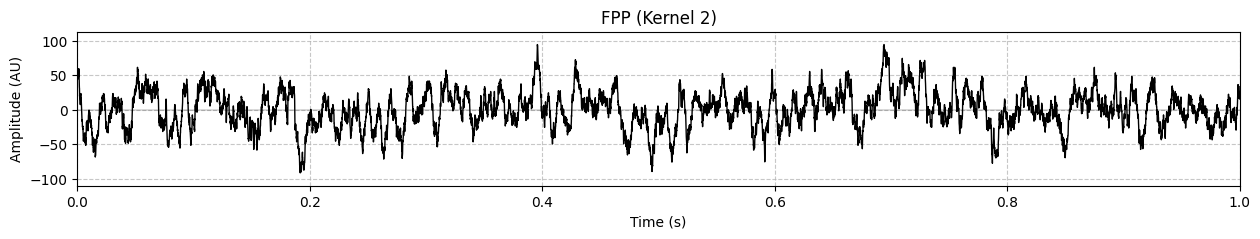

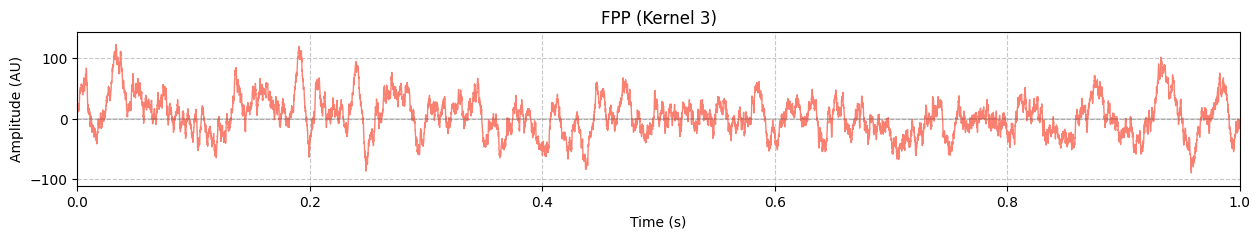

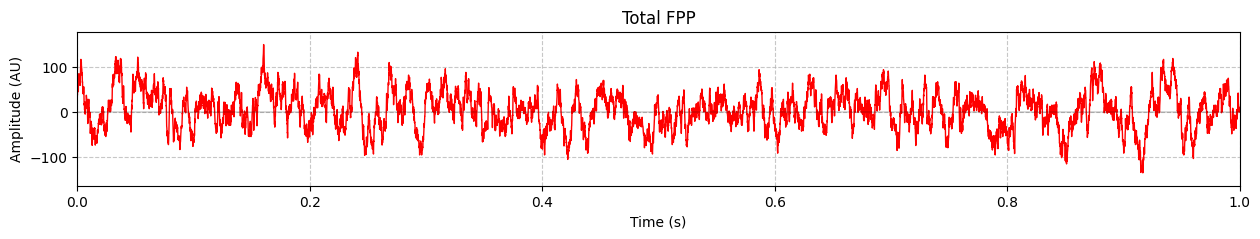

In [12]:
# The three kernels will have the same predominance 
n_neuron1, n_neuron2, n_neuron3 = (2500, 2500, 2500) 

signal_sq1, time_signal_sq1, _ = simulate_fpp(kernel = kernel_sq1,
                                              fs = fs,
                                              t_sec = t_sec, 
                                              num_neurons = n_neuron1, 
                                              rate = 50)

signal_sq2, time_signal_sq2, _ = simulate_fpp(kernel = kernel_sq2,
                                              fs = fs,
                                              t_sec = t_sec, 
                                              num_neurons = n_neuron2, 
                                              rate = 50)

signal_sq3, time_signal_sq3, _ = simulate_fpp(kernel = kernel_sq3,
                                              fs = fs,
                                              t_sec = t_sec, 
                                              num_neurons = n_neuron3, 
                                              rate = 50)

total_signal_sq_eq = signal_sq1 + signal_sq2 + signal_sq3

plot_trace(signal_sq1, time_signal_sq1, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP (Kernel 1)')
plot_trace(signal_sq2, time_signal_sq2, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP (Kernel 2)', trace_color = 'black')
plot_trace(signal_sq3, time_signal_sq3, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP (Kernel 3)', trace_color = 'salmon')
plot_trace(total_signal_sq_eq, time_signal_sq3, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'Total FPP', trace_color = 'red')

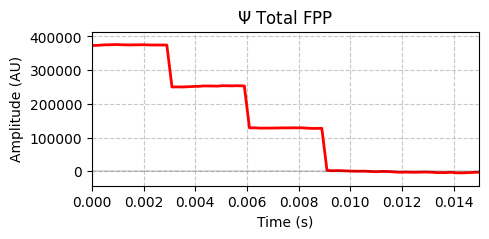

In [13]:
psi_sq_eq, time_psi_sq_eq = psi_pattern(signal = total_signal_sq_eq, fs = fs)
plot_trace(psi_sq_eq, time_psi_sq_eq, title = '$\Psi$ Total FPP', xlim = (0, 0.015), trace_color = 'red')

Now we will perform the same simulation, but in this case, the first kernel (the shortest one at 3 ms) will be considerably more predominant than the other two, as it will have a larger number of neurons associated with it.

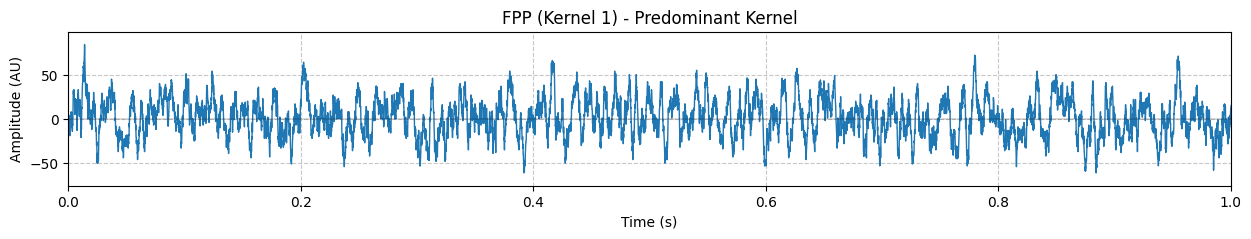

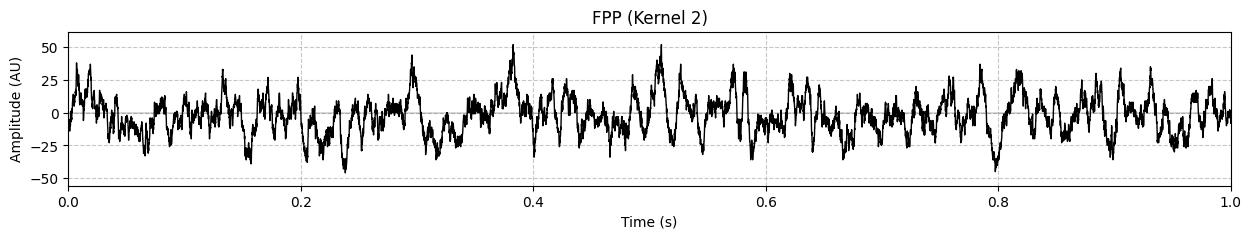

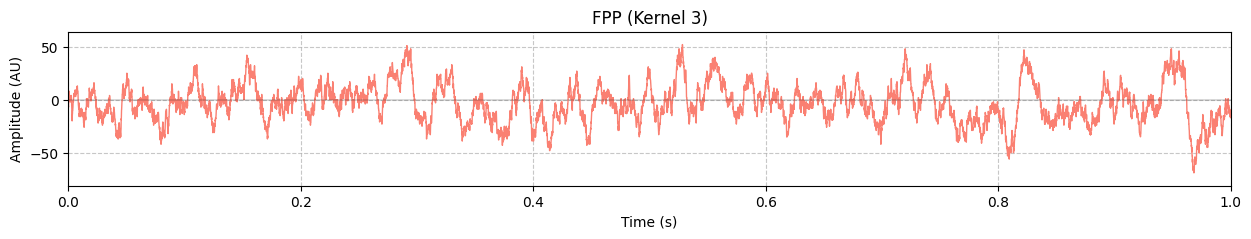

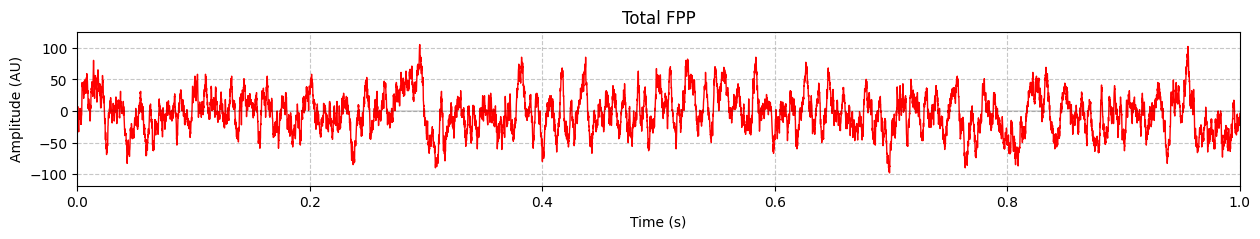

In [16]:
# The first kernel (3 ms) is considerably more predominant
n_neuron1, n_neuron2, n_neuron3 = (3000, 700, 700) 

signal_sq1, time_signal_sq1, _ = simulate_fpp(kernel = kernel_sq1,
                                              fs = fs,
                                              t_sec = t_sec, 
                                              num_neurons = n_neuron1, 
                                              rate = 50)

signal_sq2, time_signal_sq2, _ = simulate_fpp(kernel = kernel_sq2,
                                              fs = fs,
                                              t_sec = t_sec, 
                                              num_neurons = n_neuron2, 
                                              rate = 50)

signal_sq3, time_signal_sq3, _ = simulate_fpp(kernel = kernel_sq3,
                                              fs = fs,
                                              t_sec = t_sec, 
                                              num_neurons = n_neuron3, 
                                              rate = 50)

total_signal_sq_eq = signal_sq1 + signal_sq2 + signal_sq3

plot_trace(signal_sq1, time_signal_sq1, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP (Kernel 1) - Predominant Kernel')
plot_trace(signal_sq2, time_signal_sq2, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP (Kernel 2)', trace_color = 'black')
plot_trace(signal_sq3, time_signal_sq3, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'FPP (Kernel 3)', trace_color = 'salmon')
plot_trace(total_signal_sq_eq, time_signal_sq3, size = (15, 2), xlim = (0, 1), linewidth = 1, title = 'Total FPP', trace_color = 'red')

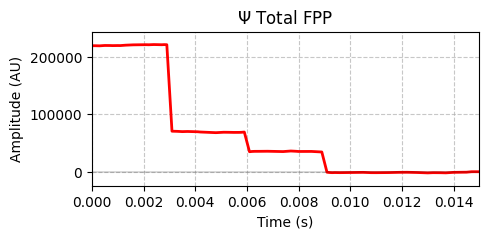

In [15]:
psi_sq_eq, time_psi_sq_eq = psi_pattern(signal = total_signal_sq_eq, fs = fs)
plot_trace(psi_sq_eq, time_psi_sq_eq, title = '$\Psi$ Total FPP', xlim = (0, 0.015), trace_color = 'red')

As we can observe, although the kernels involved are the same as in the previous case, the shift in their relative predominance results in a clear overrepresentation of Kernel 1 in the total signal's $\Psi$ pattern in this final example.

- Importantly, the $\Psi$ pattern acts as a signal signature, providing valuable information regarding the kernels present. Due to the close relationship between kernels and signal dynamics, this pattern is also highly useful for characterizing these temporal dynamics.